### Загрузка датасета COCO и кода COCO API

In [1]:
!mkdir -p data

!cd data && wget http://images.cocodataset.org/zips/train2017.zip 
!cd data && unzip -q train2017.zip
!cd data && rm train2017.zip

--2021-06-05 20:14:00--  http://images.cocodataset.org/zips/train2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.141.212
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.141.212|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19336861798 (18G) [application/zip]
Saving to: ‘train2017.zip’

train2017.zip       100%[===================>]  18.01G  51.6MB/s    in 5m 2s   

2021-06-05 20:19:02 (61.1 MB/s) - ‘train2017.zip’ saved [19336861798/19336861798]



In [2]:
!cd data && wget http://images.cocodataset.org/zips/val2017.zip 
!cd data && wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip 
  
!cd data && unzip -q val2017.zip
!cd data && unzip -q annotations_trainval2017.zip
!cd data && rm val2017.zip
!cd data && rm annotations_trainval2017.zip

!cd data && git clone https://github.com/cocodataset/cocoapi
!cd data/cocoapi/PythonAPI && make

--2021-06-05 20:26:51--  http://images.cocodataset.org/zips/val2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.185.3
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.185.3|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 815585330 (778M) [application/zip]
Saving to: ‘val2017.zip’

val2017.zip         100%[===================>] 777.80M  61.5MB/s    in 12s     

2021-06-05 20:27:03 (64.6 MB/s) - ‘val2017.zip’ saved [815585330/815585330]

--2021-06-05 20:27:03--  http://images.cocodataset.org/annotations/annotations_trainval2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.217.97.212
Connecting to images.cocodataset.org (images.cocodataset.org)|52.217.97.212|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252907541 (241M) [application/zip]
Saving to: ‘annotations_trainval2017.zip’

annotations_trainva 100%[===================>] 241.19M  78.4MB/s    in 3.1s    

2021-06-

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Импорт необходимых библиотек

In [4]:
import os
import skimage.io as io
import numpy as np

### Импорт TensorFlow

In [5]:
import tensorflow as tf
#tf.enable_eager_execution()
print('TensorFlow version:', tf.__version__)

TensorFlow version: 2.5.0


### Импорт библиотеки COCO API

In [6]:
COCO_ROOT = './data/'
import sys
sys.path.insert(0, os.path.join(COCO_ROOT, 'cocoapi/PythonAPI'))
from pycocotools.coco import COCO

### Класс Dataset

In [14]:
class Dataset():

    def crop_images(self, img, inp_size, random_crop=False):
        shape = tf.shape(img)
        pad = (
            [0, tf.maximum(inp_size - shape[0], 0)],
            [0, tf.maximum(inp_size - shape[1], 0)],
            [0, 0],
        )
        img = tf.pad(img, pad)

        if random_crop:
            img = tf.image.random_crop(img, (inp_size, inp_size, shape[2]))
        else: # central crop
            shape = tf.shape(img)
            ho = (shape[0] - inp_size) // 2
            wo = (shape[1] - inp_size) // 2
            img = img[ho:ho+inp_size, wo:wo+inp_size, :]

        return img

    def train_dataset(self, batch_size, epochs, inp_size):

        def item_to_images(item):
            random_crop = True
            img_combined = tf.py_function(self.read_images, [item], tf.uint8)
            img_combined = self.crop_images(img_combined, inp_size, random_crop)

            img = tf.cast(img_combined[...,:3], tf.float32) / np.float32(255.)
            mask_class = tf.cast(img_combined[...,3:4], tf.float32)
            return img, mask_class

        dataset = tf.data.Dataset.from_tensor_slices(self.img_list)
        dataset = dataset.shuffle(buffer_size=len(self.img_list))
        dataset = dataset.map(item_to_images)
        dataset = dataset.repeat(epochs)
        dataset = dataset.batch(batch_size, drop_remainder=True)

        return dataset

    def val_dataset(self, batch_size, inp_size):

        def item_to_images(item):
            random_crop = False
            img_combined = tf.py_function(self.read_images, [item], tf.uint8)
            img_combined = self.crop_images(img_combined, inp_size, random_crop)

            img = tf.cast(img_combined[...,:3], tf.float32) / np.float32(255.)
            mask_class = tf.cast(img_combined[...,3:4], tf.float32)
            return img, mask_class

        dataset = tf.data.Dataset.from_tensor_slices(self.img_list)
        dataset = dataset.map(item_to_images)
        dataset = dataset.batch(batch_size, drop_remainder=True)

        return dataset

### Наш класс COCO_Dataset

In [15]:
class COCO_Dataset(Dataset):

    def __init__(self, sublist):
        Dataset.__init__(self) 
        ann_file_fpath = os.path.join(COCO_ROOT, 'annotations', 'instances_'+sublist+'2017.json')
        self.coco = COCO(ann_file_fpath)
        self.cat_ids = self.coco.getCatIds(catNms=['person'])
        self.img_list = self.coco.getImgIds(catIds=self.cat_ids)

    def read_images(self, img_id):
        img_id = int(img_id.numpy())
        img_data = self.coco.loadImgs(img_id)[0]
        img_fname = '/'.join(img_data['coco_url'].split('/')[-2:])

        img = io.imread(os.path.join(COCO_ROOT, img_fname))
        if len(img.shape) == 2:
            img = np.tile(img[..., None], (1, 1, 3))

        ann_ids = self.coco.getAnnIds(imgIds=img_data['id'], catIds=self.cat_ids, iscrowd=None)
        anns = self.coco.loadAnns(ann_ids)
        mask_class = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)
        for i in range(len(anns)):
            mask_class += self.coco.annToMask(anns[i])
        mask_class = (mask_class > 0).astype(np.uint8)

        img_combined = np.concatenate([img, mask_class[..., None]], axis=2)

        return img_combined

### Создание обучающего и вализационного датасета
Сначала создаются два экземпляра класса `COCO_Dataset`, в конструкторе которого указывается тип датасета (указание для COCO - откуда какие читать изображения)

Далее вызываются функции `train_dataset` и `val_dataset` которые создают экземпляры `tf.data.Dataset` (в первом и втором случае логика и пайплайн данных в этих датасетов отличаются)

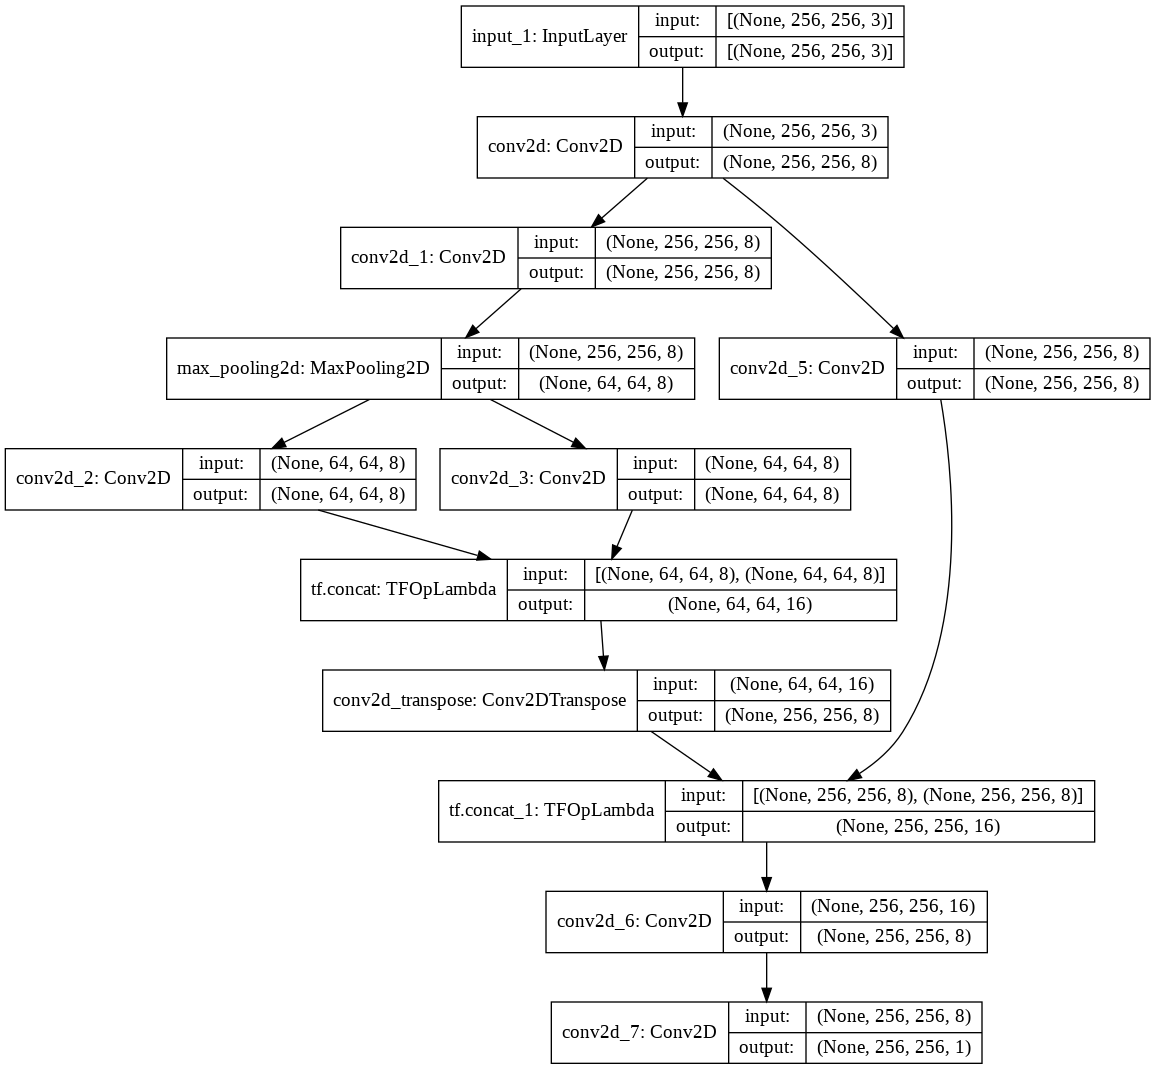

In [9]:
def build_model():
    x = tf.keras.layers.Input((256, 256, 3))

    outx = tf.keras.layers.Conv2D(8, (3, 3), padding='same', activation='relu')(x)

    # left part
    out = tf.keras.layers.Conv2D(8, (3, 3), padding='same', activation='relu')(outx)
    out = tf.keras.layers.MaxPool2D((4, 4))(out)
    out1 = tf.keras.layers.Conv2D(8, (3, 3), dilation_rate=18, padding='same', activation='relu')(out)
    out2 = tf.keras.layers.Conv2D(8, (3, 3), dilation_rate=12, padding='same', activation='relu')(out)
    out = tf.concat([out1, out2], axis=3)
    out_left = tf.keras.layers.Conv2D(8, (1, 1), padding='same', activation='relu')(out)
    out_left = tf.keras.layers.Conv2DTranspose(8, (3, 3), strides=(4, 4), padding='same', activation='relu')(out)

    #right part
    out_right = tf.keras.layers.Conv2D(8, (3, 3), padding='same', activation='relu')(outx)

    #back together
    out = tf.concat([out_left, out_right], axis=3)
    out = tf.keras.layers.Conv2D(8, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(1, (3, 3), padding='same', activation='relu')(out)

    return tf.keras.Model(inputs=x, outputs=out)
    
model = build_model()
tf.keras.utils.plot_model(model, show_shapes=True)

In [19]:
#COCO_dataset_train = COCO_Dataset('train')
#COCO_dataset_val = COCO_Dataset('val')

NUM_EPOCHS = 1
BATCH_SIZE = 64

train_ds = COCO_dataset_train.train_dataset(epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, inp_size=256)
val_ds = COCO_dataset_val.val_dataset(batch_size=BATCH_SIZE, inp_size=256)
model.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy())

history = model.fit(train_ds, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS)

1001/1001 [==============================] - 11841s 12s/step - loss: 0.4742
